In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
adata = sc.read_h5ad("NSCLC_target_mol_pred.step2.h5ad")

In [5]:
up_genes = pd.read_csv("/slurm/home/yrd/liaolab/lvtianhang/Work/WAVE_v3/13.drug_connectivity/targetmol_L6000/up_genes.csv",index_col=0)
down_genes = pd.read_csv("/slurm/home/yrd/liaolab/lvtianhang/Work/WAVE_v3/13.drug_connectivity/targetmol_L6000/down_genes.csv",index_col=0)

In [6]:
up_genes

,logFC,AveExpr,t,P.Value,adj.P.Val,B
PYCR1,3.861084,11.247226,21.474868,3.273315e-76,3.096556e-73,162.897700
TOP2A,3.893734,11.596338,19.639048,1.335071e-66,6.314884e-64,140.896047
KIF20A,3.312688,9.126252,18.612759,2.644450e-61,8.338831e-59,128.770750
KIF14,3.700130,7.991444,18.562735,4.772380e-61,1.128668e-58,128.183841
BUB1B,3.471870,8.333230,18.267224,1.547468e-59,2.927809e-57,124.725443
...,...,...,...,...,...,...
KCNK1,1.348158,10.319925,6.088396,2.043372e-09,5.619274e-09,10.453049
DDIT4,1.215659,10.719706,5.915757,5.570349e-09,1.463764e-08,9.477367
TXNRD1,1.151325,13.261924,5.442450,7.685072e-08,1.822075e-07,6.931312
CBR1,1.046073,11.472001,4.945208,9.903308e-07,2.114792e-06,4.464314


In [9]:
# 按 logFC 降序排序
up_genes_sorted = up_genes.sort_values("logFC", ascending=False)

# 提取排序后的基因名（index）
up_gene_names = up_genes_sorted.index.tolist()

In [11]:
# 按 logFC 降序排序
down_genes_sorted = down_genes.sort_values("logFC", ascending=True)

# 提取排序后的基因名（index）
down_gene_names = down_genes_sorted.index.tolist()

In [13]:
def compute_connectivity_score(qup, qdown, expression):
    ranked_expr = expression.rank(ascending=False, method="first")
    if qup and qdown:
        es_up = compute_es(qup, ranked_expr)
        es_down = compute_es(qdown, ranked_expr)
        cs = []
        for up, down in zip(es_up, es_down):
            if up * down <= 0:
                cs.append(up - down)
            else:
                cs.append(0)
        return pd.DataFrame(cs, index=expression.columns, columns=["CS"])
    
    elif qup and not qdown:
        es_up = compute_es(qup, ranked_expr)
        return pd.DataFrame(es_up, index=expression.columns, columns=["ES_up"])
    
    elif not qup and qdown:
        es_down = compute_es(qdown, ranked_expr)
        return pd.DataFrame(es_down, index=expression.columns, columns=["ES_down"])
    
    else:
        return None

def compute_es(query_genes, ranked_expr):
    if len(query_genes) == 0:
        return [0] * ranked_expr.shape[1]

    elif len(query_genes) == 1:
        single_rank = ranked_expr.loc[query_genes, :]
        single_rank.index = [0]
        return single_rank.T[0].tolist()

    else:
        n = ranked_expr.shape[0]
        subset = ranked_expr.loc[query_genes, :]
        J = subset.rank()
        a_vect = J / len(query_genes) - subset / n
        b_vect = subset / n - (J - 1) / len(query_genes)
        a = a_vect.max()
        b = b_vect.max()
        es = []
        for i in range(len(a)):
            if a[i] > b[i]:
                es.append(a[i])
            else:
                es.append(-b[i])
        return es

In [27]:
pred_expr = adata.layers['pred']
unpert_expr = adata.layers['unpert_expr']
genes = adata.var_names.tolist()

pred_expr[pred_expr < 0] = 0
unpert_expr[unpert_expr < 0] = 0

# 计算 log2FC
log2fc_matrix = np.log2((pred_expr + 1e-6) / (unpert_expr + 1e-6))  # shape: (n_obs, n_genes)

In [28]:
pred_df = pd.DataFrame(log2fc_matrix)
pred_df

,0,1,2,3,4,5,6,7,8,9,...,968,969,970,971,972,973,974,975,976,977
0,0.021723,0.232831,-0.086413,0.023178,0.160652,-0.076445,-0.015346,-0.059708,0.048157,0.018816,...,-0.030335,0.236891,-0.006734,0.030892,0.045244,-0.000110,0.007169,-0.011355,0.101872,-0.036046
1,-0.021797,0.276412,0.187022,0.226719,0.282625,-0.254440,0.049962,0.297214,0.532232,0.061602,...,-0.108684,0.555093,0.212272,0.251804,0.399044,0.139580,0.304127,0.103802,-0.077031,0.056714
2,0.014646,-0.093109,0.036447,0.033357,0.008491,0.060692,0.012532,0.158705,0.022906,-0.071002,...,0.009655,-0.153484,0.018174,0.045810,-0.139383,-0.025282,-0.000612,0.064198,-0.101292,0.024198
3,0.006529,0.172460,-0.131775,-0.006238,0.149715,-0.084843,-0.050445,-0.089026,0.023007,-0.016562,...,-0.054250,0.189966,-0.031483,-0.012194,0.045943,-0.015455,-0.021891,-0.019567,0.093887,-0.047393
4,-0.038573,0.325319,0.101672,0.090789,0.120953,-0.117273,-0.021445,0.162445,0.401313,0.067065,...,-0.034669,0.287943,0.119313,0.109468,0.289967,0.080768,0.241582,0.050744,-0.127324,0.069447
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5578,-0.017987,0.330172,0.118329,0.114186,0.105502,-0.112791,-0.045680,0.162255,0.449820,0.086368,...,-0.008225,0.296394,0.154309,0.103858,0.287143,0.099669,0.216994,0.078557,-0.111655,0.051470
5579,0.017756,-0.065770,0.020648,0.025681,-0.040488,0.092156,-0.008552,0.138492,-0.000813,-0.064171,...,0.018538,-0.125132,0.001915,0.035236,-0.142677,-0.015013,0.005255,0.057864,-0.120547,0.044402
5580,0.025018,0.159333,-0.111166,-0.053285,0.049548,-0.030127,-0.123589,-0.156368,0.021897,-0.003112,...,-0.016480,0.182781,-0.015182,-0.127203,-0.060061,-0.022126,-0.071932,-0.008845,0.076968,-0.056098
5581,-0.004596,0.339089,0.139884,0.082700,0.074625,-0.093219,-0.122128,0.139095,0.449832,0.073270,...,-0.054434,0.311718,0.161386,0.006229,0.163349,0.085513,0.215596,0.095580,-0.145203,0.066318


In [29]:
drug_df = pd.read_csv("/slurm/home/yrd/liaolab/lvtianhang/Work/WAVE_v3/13.drug_connectivity/targetmol_L6000/Targetmol_L6000.csv", encoding='latin1')
id_drugName = dict(zip(drug_df['ID'], drug_df['Name']))
adata.obs['Name'] = adata.obs['IDNUMBER'].map(id_drugName)

In [30]:
adata.obs

,smiles,Cas,IDNUMBER,cell,Name
0,CC1=CC(=O)[C@@H](O)[C@@]2(C)[C@H]1C[C@H]1OC(=O...,21499-66-1,TWS2045,A549,Bruceine D
1,CC1=CC(=O)[C@@H](O)[C@@]2(C)[C@H]1C[C@H]1OC(=O...,21499-66-1,TWS2045,A549,Bruceine D
2,CC1=CC(=O)[C@@H](O)[C@@]2(C)[C@H]1C[C@H]1OC(=O...,21499-66-1,TWS2045,A549,Bruceine D
3,CC(C)[C@]12CC[C@@](C)(O1)[C@H](O)CC\C(C)=C\CC\...,22419-74-5,TWS1563,A549,Incensole
4,CC(C)[C@]12CC[C@@](C)(O1)[C@H](O)CC\C(C)=C\CC\...,22419-74-5,TWS1563,A549,Incensole
...,...,...,...,...,...
5578,O[C@H]([C@H]1C[C@@H]2CC[N@]1C[C@@H]2C=C)c1ccnc...,118-10-5,T0012,A549,Cinchonine
5579,O[C@H]([C@H]1C[C@@H]2CC[N@]1C[C@@H]2C=C)c1ccnc...,118-10-5,T0012,A549,Cinchonine
5580,OCCC1=CC=CC=C1,60-12-8,T0011,A549,Phenethyl alcohol
5581,OCCC1=CC=CC=C1,60-12-8,T0011,A549,Phenethyl alcohol


In [31]:
pred_df.index = adata.obs['Name']
pred_df.columns = adata.var_names.tolist()
pred_df1 = pred_df.T
pred_df1

Name,Bruceine D,Bruceine D,Bruceine D,Incensole,Incensole,Incensole,Angelic anhydride,Angelic anhydride,Angelic anhydride,Aristolone,...,Betaine hydrochloride,cis-Anethol,cis-Anethol,cis-Anethol,Cinchonine,Cinchonine,Cinchonine,Phenethyl alcohol,Phenethyl alcohol,Phenethyl alcohol
GNPDA1,0.021723,-0.021797,0.014646,0.006529,-0.038573,0.002553,0.004290,-0.015978,0.014605,0.004357,...,0.007831,0.005254,-0.013181,0.015553,-0.001335,-0.017987,0.017756,0.025018,-0.004596,0.025677
CDH3,0.232831,0.276412,-0.093109,0.172460,0.325319,-0.051419,0.162654,0.336827,-0.066233,0.162205,...,-0.071710,0.161306,0.320315,-0.063499,0.161706,0.330172,-0.065770,0.159333,0.339089,-0.073311
HDAC6,-0.086413,0.187022,0.036447,-0.131775,0.101672,0.015820,-0.124864,0.101933,0.016278,-0.124872,...,0.020123,-0.127455,0.112061,0.020079,-0.129494,0.118329,0.020648,-0.111166,0.139884,0.032924
PARP2,0.023178,0.226719,0.033357,-0.006238,0.090789,0.027526,-0.025609,0.100071,0.023990,-0.024384,...,0.026737,-0.027093,0.114276,0.027300,-0.033646,0.114186,0.025681,-0.053285,0.082700,-0.020108
MAMLD1,0.160652,0.282625,0.008491,0.149715,0.120953,-0.040667,0.065344,0.081420,-0.038927,0.068501,...,-0.036426,0.066902,0.102440,-0.044894,0.053350,0.105502,-0.040488,0.049548,0.074625,-0.055141
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CDC25B,-0.000110,0.139580,-0.025282,-0.015455,0.080768,-0.018923,-0.013556,0.096966,-0.013986,-0.012442,...,-0.019081,-0.012684,0.101211,-0.014062,-0.016168,0.099669,-0.015013,-0.022126,0.085513,-0.021438
OXSR1,0.007169,0.304127,-0.000612,-0.021891,0.241582,-0.006283,-0.053750,0.211463,0.000130,-0.052972,...,-0.005074,-0.061053,0.214596,0.002641,-0.055740,0.216994,0.005255,-0.071932,0.215596,-0.008678
MVP,-0.011355,0.103802,0.064198,-0.019567,0.050744,0.066808,-0.019656,0.076570,0.060713,-0.020130,...,0.054357,-0.017442,0.078579,0.055539,-0.022339,0.078557,0.057864,-0.008845,0.095580,0.097138
CDC42,0.101872,-0.077031,-0.101292,0.093887,-0.127324,-0.124070,0.088416,-0.130282,-0.128219,0.088684,...,-0.127302,0.091619,-0.112870,-0.124815,0.084546,-0.111655,-0.120547,0.076968,-0.145203,-0.132438


In [32]:
cs_result = compute_connectivity_score(up_gene_names, down_gene_names, pred_df1)

In [33]:
cs_result

,CS
Name,
Bruceine D,0.173923
Bruceine D,0.000000
Bruceine D,0.299383
Incensole,-0.172742
Incensole,0.000000
...,...
Cinchonine,0.000000
Cinchonine,0.246169
Phenethyl alcohol,0.000000


In [34]:
cs_result['CS'].max()

0.4316027039456851

In [35]:
cs_result['CS'].min()

-0.44435459809189204

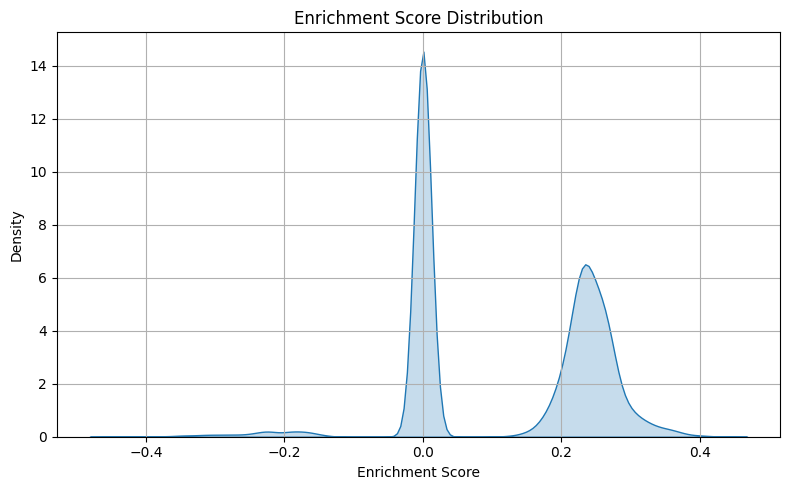

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你的分数保存在 scores 列表中
plt.figure(figsize=(8, 5))
sns.kdeplot(cs_result['CS'], fill=True, bw_adjust=0.5)

plt.title("Enrichment Score Distribution")
plt.xlabel("Enrichment Score")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
cs_result

,CS
Name,
Bruceine D,0.173923
Bruceine D,0.000000
Bruceine D,0.299383
Incensole,-0.172742
Incensole,0.000000
...,...
Cinchonine,0.000000
Cinchonine,0.246169
Phenethyl alcohol,0.000000


In [42]:
# 1. 去重：对于重复的药物，取其最小的 CS 值（或者你也可以选择其他方法，如取均值）
cs_unique = cs_result.groupby(cs_result.index).min()

# 2. 筛选出逆转效应药物（CS < 0）
reverse_effects = cs_unique[cs_unique['CS'] < 0]

# 3. 按 CS 从低到高排序（越低表示逆转效应越强）
top50 = reverse_effects.sort_values(by='CS').head(50)

top50['Name'] = top50.index

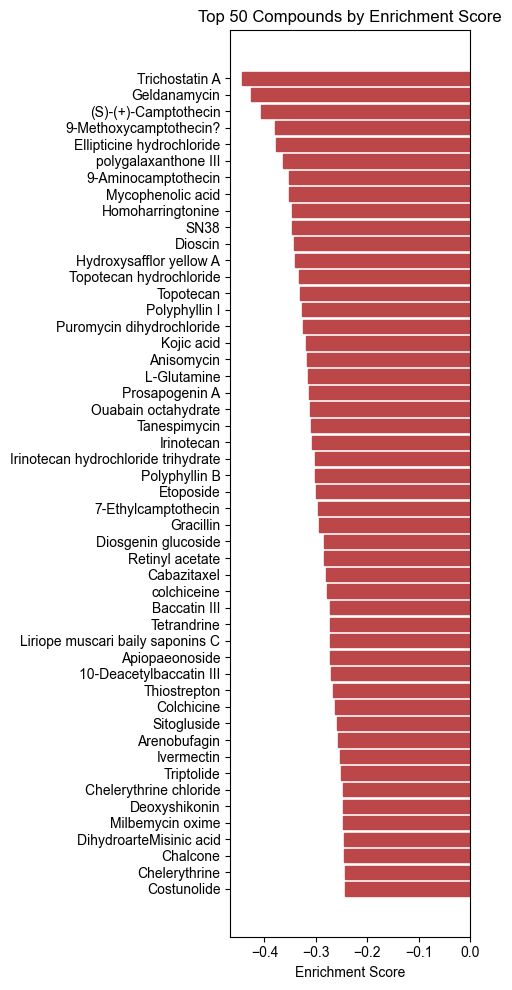

In [44]:
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['pdf.fonttype'] = 42  # 避免 PDF 字体子集化（42=非嵌入型字体）
matplotlib.rcParams['svg.fonttype'] = 'none'  # SVG 禁止字体转为路径

# 绘图
plt.figure(figsize=(5, 10))
bars = plt.barh(top50['Name'], top50['CS'], color='lightgray')
for i in range(len(top50)):
    bars[i].set_color('#bc4749')  # top50 全部设为红色

plt.xlabel("Enrichment Score")
plt.ylabel("")
plt.title("Top 50 Compounds by Enrichment Score")
plt.gca().invert_yaxis()  # 让排名高的在上方
plt.tight_layout()
plt.savefig("top50_score.raw_expr.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [45]:
reference_smiles = [
    "CN1C=C(C2=CC=CC=C21)C3=NC(=NC=C3)NC4=C(C=C(C(=C4)NC(=O)C=C)N(C)CCN(C)C)OC",  # Osimertinib
    "COC1=CC=CC=C1NC2=NC=C(C=C2OC)NC3=CC=CC=C3",  # Gefitinib
    "COCCOc1cc2c(cc1OCCOC)ncnc2Nc3cccc(c3)C#C",  # Erlotinib
    "COC1=C(C=C2C(=C1)N=CN=C2NC3=CC(=C(C=C3)F)Cl)NC(=O)/C=C/CN4CCCCC4",  # Dacomitinib
    "COc1cc(ccc1Nc1ncc(Cl)c(Nc2ccccc2P(C)(C)=O)n1)N1CCC(CC1)N1CCN(C)CC1",  # Brigatinib
    "CC1=CC(=O)N(C2=CC=CC=C12)C3=CC=C(C=C3)C(=O)NC4=CC=CC=C4",  # Sotorasib
    "CC1=CC=C(C=C1)C2=NC(=NC=C2)NC3=CC=CC=C3",  # Repotrectinib
    "CC(C)(C)C1=CC=C(C=C1)NC(=O)C2=CC=CC=C2"  # Telaglenastat
]

In [47]:
drug_df

,ID,Name,CAS,SMILES
0,TWS2045,Bruceine D,21499-66-1,CC1=CC(=O)[C@@H](O)[C@@]2(C)[C@H]1C[C@H]1OC(=O...
1,TWS1563,Incensole,22419-74-5,CC(C)[C@]12CC[C@@](C)(O1)[C@H](O)CC\C(C)=C\CC\...
2,TWS1293,Angelic anhydride,94487-74-8,C\C=C(\C)C(=O)OC(=O)C(\C)=C/C
3,TWS1229,Aristolone,25274-27-5,C[C@@H]1CCCC2=CC(=O)[C@@H]3[C@@H](C3(C)C)[C@@]12C
4,TWS0787,Oroxin A,31567-75-6,OC[C@H]1O[C@@H](Oc2cc3oc(cc(=O)c3c(O)c2O)-c2cc...
...,...,...,...,...
1856,T0021,Vanatone,70-70-2,CCC(=O)c1ccc(O)cc1
1857,T0019,Betaine hydrochloride,590-46-5,[Cl-].C[N+](C)(C)CC(O)=O
1858,T0014,cis-Anethol,104-46-1,COc1ccc(C=CC)cc1
1859,T0012,Cinchonine,118-10-5,O[C@H]([C@H]1C[C@@H]2CC[N@]1C[C@@H]2C=C)c1ccnc...


In [48]:
drugName_smiles = dict(zip(drug_df['Name'], drug_df['SMILES']))
top50['smiles'] = top50['Name'].map(drugName_smiles)

In [49]:
candidate_smiles = top50['smiles'].tolist()

In [50]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 生成RDKit分子对象
def smiles_to_mol(smiles_list):
    return [Chem.MolFromSmiles(smiles) for smiles in smiles_list]

# 计算摩根指纹
def get_morgan_fps(mol_list, radius=2, n_bits=2048):
    return [AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits) for mol in mol_list]

# 计算相似度矩阵
def compute_similarity_matrix(fps1, fps2):
    similarity_matrix = []
    for fp1 in fps1:
        row = DataStructs.BulkTanimotoSimilarity(fp1, fps2)
        similarity_matrix.append(row)
    return np.array(similarity_matrix)

# 转换SMILES为分子对象
candidate_mols = smiles_to_mol(candidate_smiles)
reference_mols = smiles_to_mol(reference_smiles)

# 计算指纹
candidate_fps = get_morgan_fps(candidate_mols)
reference_fps = get_morgan_fps(reference_mols)

# 计算相似度矩阵
similarity_matrix = compute_similarity_matrix(candidate_fps, reference_fps)


[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerator
[21:21:25] DEPRECATION WARNING: please use MorganGenerat

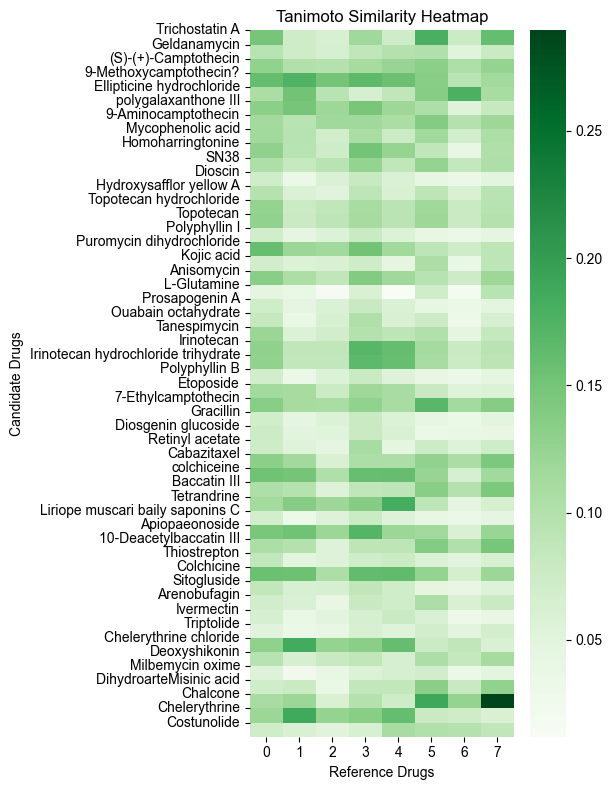

In [51]:
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['Arial']
matplotlib.rcParams['pdf.fonttype'] = 42  # 避免 PDF 字体子集化（42=非嵌入型字体）
matplotlib.rcParams['svg.fonttype'] = 'none'  # SVG 禁止字体转为路径

# 创建DataFrame用于热图

similarity_df = pd.DataFrame(
    similarity_matrix,
    index=top50['Name'].tolist(),
    #columns=drug_df[0].tolist()
)

# 绘制热图
plt.figure(figsize=(6, 8))
sns.heatmap(similarity_df, annot=False, cmap="Greens", fmt=".2f")
plt.title("Tanimoto Similarity Heatmap")
plt.xlabel("Reference Drugs")
plt.ylabel("Candidate Drugs")

plt.yticks(ticks=np.arange(len(similarity_df.index)), labels=similarity_df.index, rotation=0)
plt.tick_params(axis='y', labelsize=10)
plt.tight_layout()
plt.savefig("top50_score.sim_with_drug.raw_expr.v2.pdf", format="pdf", bbox_inches="tight")
plt.show()
